Net IDs: hak68, ota3 

# Research Questions


- Can we predict how much a patient pays for diabetes care considering the factors that go into their care?
- Based on how long a patient stays in hospital and how much they spent, can we predict what factors went into their care?



# Data collection and cleaning

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb


In [23]:
attributes_df = pd.read_csv("../info2950-final-project/Attribute_Description.csv")
medication_df = pd.read_csv("Medication_Data_Kaggle_V1.csv")
socio_eco_df = pd.read_csv("Socio_Economics_Data_Kaggle_V1.csv")
patient_data_training_df = pd.read_csv("Patient_Data_Training_Kaggle_V1.csv")

**Renaming column names to include no spaces for simpler selection**

In [24]:
def rename_column(colname):
  return colname.replace(' ', '_')

medication_df = medication_df.rename(mapper = rename_column, axis = 1)
socio_eco_df = socio_eco_df.rename(mapper = rename_column, axis = 1)
patient_data_training_df = patient_data_training_df.rename(mapper = rename_column, axis = 1)




**Combining into one dataframe**

# Data description

**What are the observations (rows) and the attributes (columns)?**

Each dataframe, medication_df, socio_eco_df, and patient_data_training_df are a part of the same larger set of data but split into different dataframes. This larger dataframe observes certain attributes for each diabetes patient, recognized by their unique patient id (each row is data for one patient). 

The patient_data_training_df has attributes about general demograhics of the patient, the many factors that might have went into a ptient's diabetes care, and the cost of care for each patient:
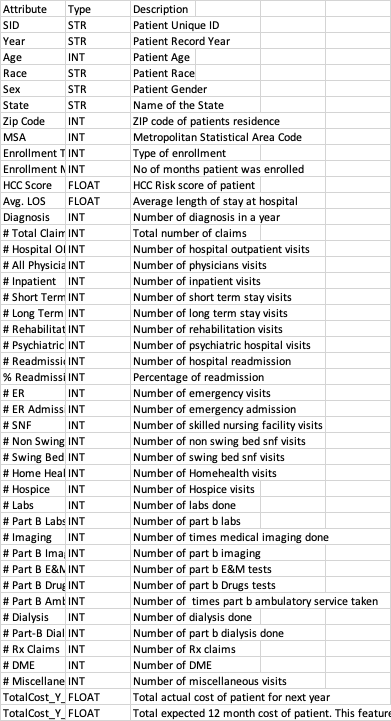

The medication_df has types of medication taken by the patient as attributes and the values in each row are binary, either a 0 or 1 indicating no the patient did not take this medication, or yes, they did:
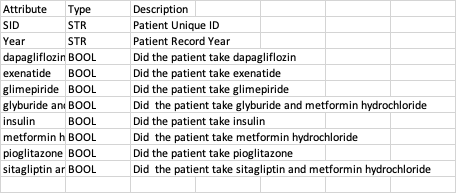

The socio_eco_df has attributes concerning a patient's socio-economic background: 
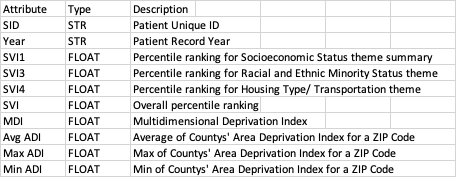



**Why was this dataset created?**

This data set was created to analyze the factors that go into diabetes care, the demographics of diabetes patients, and how much it cost these patients to get care.

**Who funded the creation of the dataset?**

We do not know who funded the creation of this dataset, but we know that it was posted by someone named Majid Ahmad Khan who is a data scientist

**What processes might have influenced what data was observed and recorded and what was not?**


**What preprocessing was done, and how did the data come to be in the form that you are using?**


**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**


**Where can your raw source data be found, if applicable?**

# Data limitations

One limitation of our data is that there is a total cost of patient care for that year, but the indivudal factors that went into the care are not priced. So we do not explicity know which factors such as medication taken, length of stay, treatments given etc. affected the total price the most. We will have to find out these prices through predictions from our model intead of observed occurences in real life. When trying to predict these prices, our model might have oddities or outliers that might make it difficult for us to confidently make predictions for these values.
Another limitation of our data is regarding the lack of information we have about what some of the columns are trying to portray. For example, there are columns SVI1, SVI3, SVI4, and SVI that measure percentile rankings for various socioeconomic and ethnic status. However, some of these values are negative numbers that are also greater than 1 and all of the positive numbers are less than 1. So, do negative percentiles have any significance? Are the percentile values out of 1 or out of 100? Or is the data in these columns simply meaningless? These are the questions we have to consider in our analysis and if we decide to not use those columns at all, then we lose information about a patient's socioeconomic status when creating our model.

# Exploratory data analysis

**Based on the medication taken, how much did the patients spend on diabetes treatment?** This bar graph shows the total cost of care for the patients that used each medication(value = 1) and on the same graph shows the total cost of care for the patients that didn't use the medication(value = 0). We thought this would be useful for our research because this comparison shows the how important the use of each medication affects the cost of the overallcare 

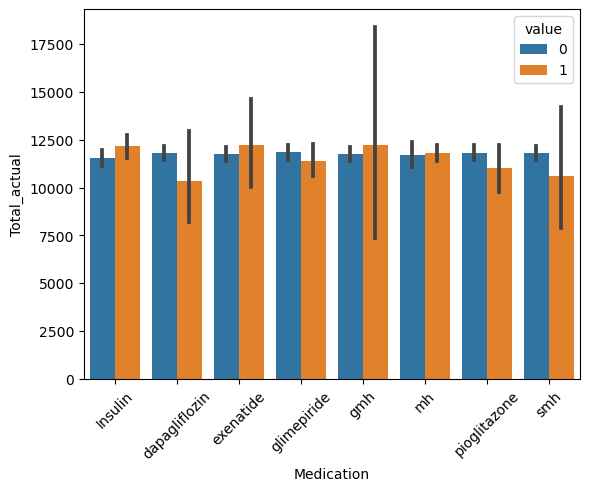

In [25]:
#assign variables that goes into the medication dataframe
ID = medication_df['ID']
Insulin = medication_df['insulin']
dapagliflozin = medication_df['dapagliflozin']
exenatide = medication_df['exenatide']
glimepiride =medication_df['glimepiride']
gmh = medication_df['glyburide_and_metformin_hydrochloride']
mh = medication_df['metformin_hydrochloride']
pioglitazone = medication_df['pioglitazone']
smh = medication_df['sitagliptin_and_metformin_hydrochloride']
 
#assign variables that goes into patients dataframe 
ID = patient_data_training_df['ID']
Cost_actual = patient_data_training_df['TotalCost_Y_Actual']
stays = patient_data_training_df['Avg._LOS']

#make a dataframe of each data 
sub_medication_df = pd.DataFrame({'ID': ID, 'Insulin': Insulin, 'dapagliflozin': dapagliflozin, 'exenatide':
exenatide, 'glimepiride':glimepiride, 'gmh': gmh, 'mh' : mh, 'pioglitazone': pioglitazone, 'smh': smh})

sub_patient_df = pd.DataFrame({'ID': ID, 'Total_actual': Cost_actual, 'avg_stay': stays})

#combine necessary values from both dataframes
merge_df = duckdb.sql("SELECT * FROM sub_patient_df INNER JOIN sub_medication_df ON sub_patient_df.ID = \
sub_medication_df.ID").df()

melted_df = pd.melt(merge_df, id_vars = ['ID', 'Total_actual'],
                                  value_vars = ['Insulin', 'dapagliflozin', 'exenatide', 'glimepiride', 'gmh','mh', 
                                                'pioglitazone', 'smh'], var_name='Medication')
melted_df = melted_df.dropna()

#Based on medication taken, total cost of treatment of patient for that year
sns.barplot(data=melted_df, x="Medication", y="Total_actual", hue="value")
plt.xticks(rotation = 45)
plt.show()

**What type of care is most common among diabetes patients** This bar graph shows the different types of care the patients recieved during their treatment this allows us to see the most common treatment among the patients and is important to our research question to make sure that we can include this factor while considering the other factors that impact each patients cost of care 

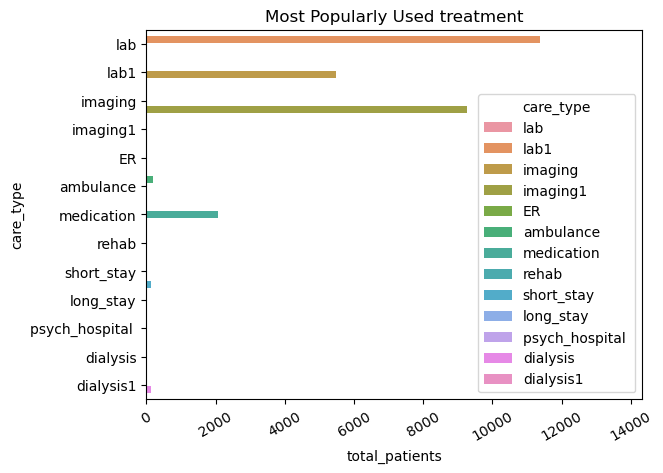

In [26]:
#types of care 
ER = patient_data_training_df['#_ER']
lab = patient_data_training_df['#_Labs']
lab1 = patient_data_training_df['#_Part_B_Labs']
imaging = patient_data_training_df['#_Imaging']
imaging1 = patient_data_training_df['#_Part_B_Imaging']
ambulance = patient_data_training_df['#_Part_B_Ambulance']
medication = patient_data_training_df['#_Part_B_Drugs']
rehab = patient_data_training_df['#_Rehabilitation_Hospital']
psych_hospital = patient_data_training_df['#_Psychiatric_Hospital']
physician_visit = patient_data_training_df['#_All_Physician_OP']
dialysis = patient_data_training_df['#_Dialysis']
dialysis1 = patient_data_training_df['#_Part-B_Dialysis']
short_stay = patient_data_training_df['#_Short_Term_Stay_Hospital']
long_stay = patient_data_training_df['#_Long_Term_Stay_Hospital']
Race = patient_data_training_df['Race']


#data frame for types of care 
care_df = pd.DataFrame({'ID': ID, 'lab': lab, 'lab1': lab1, 'imaging': imaging, 'imaging1': imaging1, 'ER': ER,
'ambulance': ambulance,'medication': medication, 'rehab': rehab, 'short_stay': short_stay,'long_stay': long_stay,
'psych_hospital': psych_hospital, 'physician_visit': physician_visit, 'dialysis': dialysis, 'dialysis1':dialysis1})


treatment_used = (care_df > 1).sum()

treatment_used_df = pd.DataFrame({'care_type':['lab', 'lab1', 'imaging','imaging1','ER', 'ambulance', 'medication',
'rehab', 'short_stay', 'long_stay', 'psych_hospital ', 'dialysis', 'dialysis1'],
'total_patients':[13655, 11379, 5480, 9271, 0, 177, 2076, 5, 141, 0, 3, 121, 124]})

sns.barplot(data=treatment_used_df, x="total_patients", y="care_type", hue="care_type", width = 3)
plt.title('Most Popularly Used treatment')
plt.xticks(rotation = 30)
plt.show()

**Based on medication taken, total cost of treatment of patient for that year** This graph shows the average stay of patients depending on what type of medication they used. Although there it is no significant difference to tell which medication had the most impact, it is still important to see that the average length of stay in the hospital by the patients is the same regardless of what type of medications taken by the patients and this can help us answer our question taking that into account 

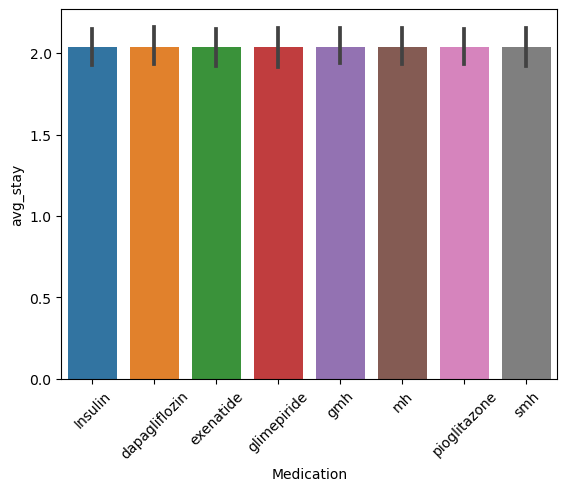

In [27]:
sub_medication_df = pd.DataFrame({'ID': ID, 'Insulin': Insulin, 'dapagliflozin': dapagliflozin, 'exenatide':
exenatide, 'glimepiride':glimepiride, 'gmh': gmh, 'mh' : mh, 'pioglitazone': pioglitazone, 'smh': smh})

sub_patient_df = pd.DataFrame({'ID': ID, 'avg_stay': stays})

#combine necessary values from both dataframes
merge_df = duckdb.sql("SELECT * FROM sub_patient_df INNER JOIN sub_medication_df ON sub_patient_df.ID = \
sub_medication_df.ID").df()

meds_stay_df  = pd.melt(merge_df, id_vars = ['ID', 'avg_stay'],
                                  value_vars = ['Insulin', 'dapagliflozin', 'exenatide', 'glimepiride', 'gmh','mh', 
                                                'pioglitazone', 'smh'], var_name='Medication')
meds_stay_df  = meds_stay_df .dropna()
meds_stay_df 

#Based on medication taken, total cost of treatment of patient for that year
sns.barplot(data=meds_stay_df, x="Medication", y="avg_stay")
plt.xticks(rotation = 45)
plt.show()

**Which medications are popular amoung diabetes patients?**
If we know the medication that is most used by diabetes patients, we can compare the attriibuts of patients who take the most popular medication to patients who take the least popular one such as how much they spent total on care, how long they stay in the hospital, how many times readmitted and see if there is any correlation. We can potentially use these correlations as an indicator of how effective a medication is in diabetes care. For example, if patients who take medication A spend twice as long in hospitals, that provides an interesting correlation to examine further. We, however, need to keep in mind that correlation does not equal causation so we might have to reexamine our definition of effectiveness.
As a bonus, we can use information about this medication such as which company makes it and we could research how much that company makes from this medication. We could perhaps find some correlation between the popularity of the diabetes medication and the success of the company that creates it to see which companies make the most off of chronic diabetes. This could lead to a interesting research question about which chronic diseases aremost profitable but we will again need more data from that

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'dapagliflozin'),
  Text(1, 0, 'exenatide'),
  Text(2, 0, 'glimepiride'),
  Text(3, 0, 'glyburide_and_metformin_hydrochloride'),
  Text(4, 0, 'insulin'),
  Text(5, 0, 'metformin_hydrochloride'),
  Text(6, 0, 'pioglitazone'),
  Text(7, 0, 'sitagliptin_and_metformin_hydrochloride')])

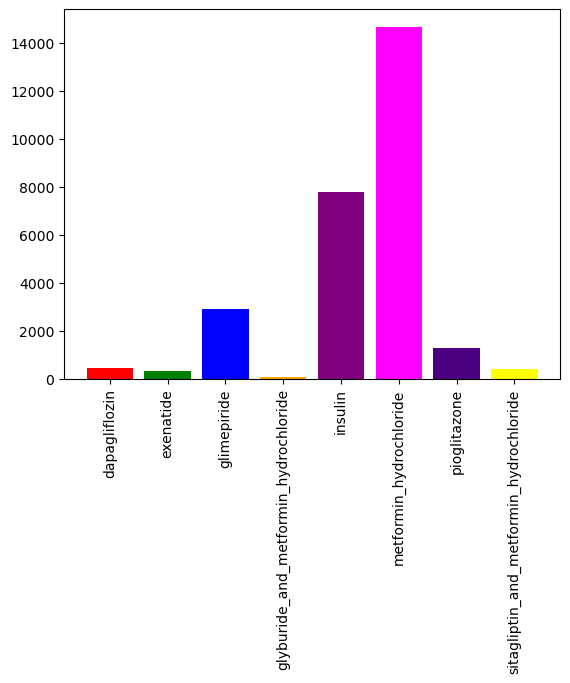

In [28]:
medication_df.head()
med_list = ['dapagliflozin', 'exenatide', 'glimepiride', \
            'glyburide_and_metformin_hydrochloride', \
            'insulin', 'metformin_hydrochloride', 'pioglitazone', \
            'sitagliptin_and_metformin_hydrochloride']

pop_med_df = np.sum(medication_df[med_list], axis = 0)


plt.bar(med_list, pop_med_df,\
        color = ['red', 'green', 'blue', 'orange', 'purple', \
                 'magenta', 'indigo', 'yellow'])
plt.xticks(rotation = 90)

**Impact of quality of area on amount spent on diabetes care:** The Area Deprivation Index (ADI) is a measure of the quality of the area a person lives in in terms of cleanliness, infrastructure, income, education, and employment rates. High ADI means high deprivation in area. It would be helpful to know more about the background of the patients and to see if there is any correlation between the ADI and how much they pay for care. It could answer questions such as do poorer individuals pay more or less for care?

Text(0, 0.5, 'Diabetes Care (\\$)')

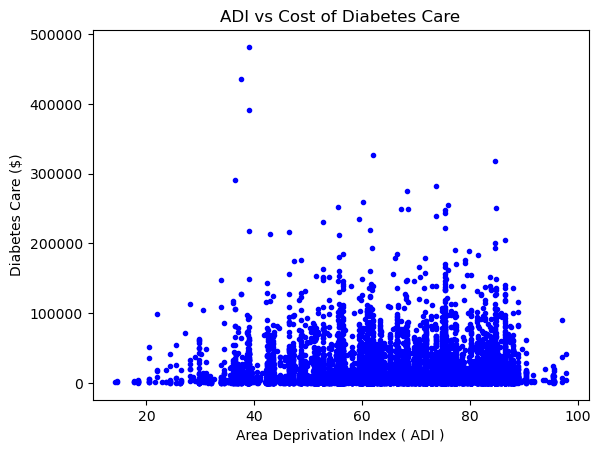

In [29]:
adi_vs_cost_df = duckdb.sql('SELECT socio_eco_df.ID, \
socio_eco_df.Avg_ADI, patient_data_training_df.TotalCost_Y_Actual AS Total_Cost \
FROM socio_eco_df \
INNER JOIN patient_data_training_df \
ON socio_eco_df.ID = patient_data_training_df.ID ').df()

plt.plot(adi_vs_cost_df['Avg_ADI'],adi_vs_cost_df['Total_Cost'],'b.')
plt.title('ADI vs Cost of Diabetes Care')
plt.xlabel('Area Deprivation Index ( ADI )')
plt.ylabel('Diabetes Care (\$)')

This scatterplot is a bit difficult to analyze as there is not a clear correlation between ADI and money spent. There are some outliers near a deprivation index of 40 but this visualization is not enough to make predictions based off of so we might not use this comparison

**Which age-group gets diabetes the most**

[Text(0.5, 1.0, 'Diabetes by Age')]

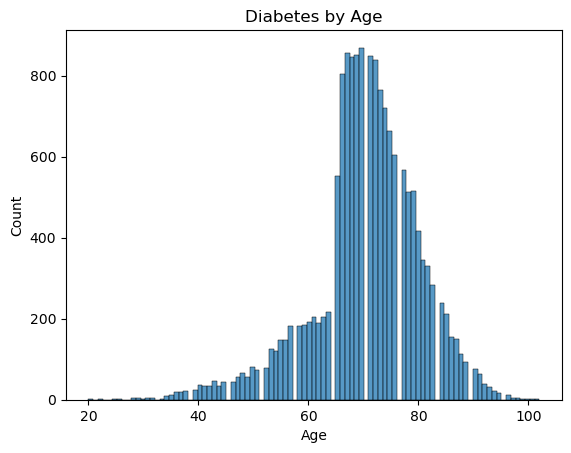

In [30]:
#min age = 20
#max age = 102

sns.histplot(patient_data_training_df[['Age']], x = "Age").set(title = "Diabetes by Age")


**How Long on Average Do Diabetes Patients Stay In Hospital?**

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'White'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Other Race'),
  Text(3, 0, 'UnKnown'),
  Text(4, 0, 'Hispanic'),
  Text(5, 0, 'Asian'),
  Text(6, 0, 'North American Native')])

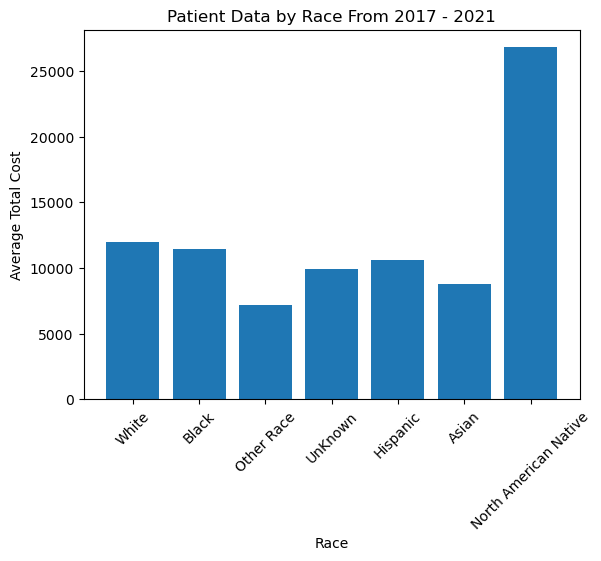

In [31]:
p = duckdb.sql("SELECT AVG(TotalCost_Y_Actual) AS Avg_Cost, Race FROM patient_data_training_df GROUP BY Race").df()

plt.bar(p['Race'], p['Avg_Cost'])
plt.xlabel('Race')
plt.ylabel('Average Total Cost')
plt.title('Patient Data by Race From 2017 - 2021')
plt.xticks(rotation = 45)

*This bar graph was created to show a comparison of how much patients pay in total for their hospital stays and medication on average based on race. The Native American's average total cost significantly outnumbers the other races.*

**Total Cost of Patient Care Per Year** This bar graph is a comparison of patients' average length of stay in the hospital based on race. This graph exhibits how White people have significantly longer stays in the hospital due to their conditions and 'other races' not defined spend the least amount of time in the hospitals due to their conditions.

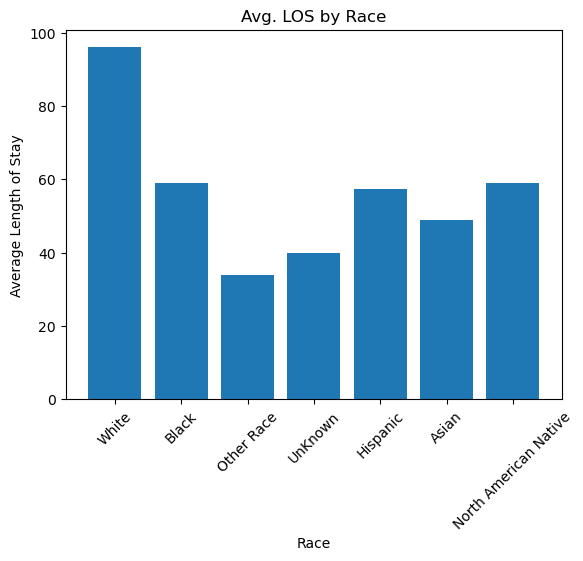

In [32]:
plt.bar(patient_data_training_df['Race'], patient_data_training_df['Avg._LOS'])
plt.xlabel('Race')
plt.ylabel('Average Length of Stay')
plt.title('Avg. LOS by Race')
plt.xticks(rotation = 45)
plt.show()

# Questions for Reviewers

- A research question we are considering is measuring the effectiveness of certain attributes on diabetes care. To do this, we would have to define a measure of effectiveness such as cost or duration of stay, but we think this could lead to us concluding causations from our data. Is this something we should be weary of or how do you reccomend avoiding this?
- Would a multivariate regression where different care attributes are inputs and the cost or duration of stay is an output be appropriate for our research question? 
- Can you reccomend places for us to find good unclean data?
- For the graph on "Based on medication taken, total cost of treatment of patient for that year" should we include this in our research even though there is no significant difference that can be explained just by looking at the graph 